In [47]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from IPython.display import Markdown, display, Image
import warnings
warnings.filterwarnings('ignore')

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf
import pandas as pd
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler, RobustScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
sns.set()

In [49]:
from file_handler import FileHandler
#from clean_data import Clean_data
import plots

In [50]:
file_handler = FileHandler()


In [51]:
train = file_handler.read_csv("../data/clean_train.csv")
test = file_handler.read_csv("../data/clean_test.csv")

In [52]:
display(train.head())
display(train.describe())
display(train.info())

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,2015-07-31,1,5,5263.0,555.0,1,1,0,1
1,2015-07-31,2,5,6064.0,625.0,1,1,0,1
2,2015-07-31,3,5,8314.0,821.0,1,1,0,1
3,2015-07-31,4,5,13611.5,1454.0,1,1,0,1
4,2015-07-31,5,5,4822.0,559.0,1,1,0,1


,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,824541.000000,824541.000000,824541.000000,824541.000000,824541.0,824541.000000,824541.000000
mean,558.082551,3.529633,6680.522184,717.839249,1.0,0.441068,0.193694
std,323.038067,1.718801,2538.267904,277.983985,0.0,0.496515,0.395192
min,1.000000,1.000000,46.000000,8.000000,1.0,0.000000,0.000000
25%,278.000000,2.000000,4823.000000,516.000000,1.0,0.000000,0.000000
50%,558.000000,4.000000,6296.000000,668.000000,1.0,0.000000,0.000000
75%,840.000000,5.000000,8179.000000,872.000000,1.0,1.000000,0.000000
max,1115.000000,7.000000,13611.500000,1454.000000,1.0,1.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824541 entries, 0 to 824540
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           824541 non-null  object 
 1   Store          824541 non-null  int64  
 2   DayOfWeek      824541 non-null  int64  
 3   Sales          824541 non-null  float64
 4   Customers      824541 non-null  float64
 5   Open           824541 non-null  int64  
 6   Promo          824541 non-null  int64  
 7   StateHoliday   824541 non-null  object 
 8   SchoolHoliday  824541 non-null  int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 56.6+ MB


None

In [53]:
def get_feature(df):
    return df[["Date", "Sales"]]

In [54]:
def drop_closed(df):
    df = df[df['Open'] == 1]
    return df

In [55]:
def scaler(df, columns, mode="minmax"):
    if (mode == "minmax"):
        minmax_scaler = MinMaxScaler()
        return pd.DataFrame(minmax_scaler.fit_transform(df), columns=columns), minmax_scaler
    elif (mode == "standard"):
        scaler = StandardScaler()
        return pd.DataFrame(scaler.fit_transform(df), columns=columns), scaler
    elif (mode == "robust"):
        scaler = RobustScaler()
        return pd.DataFrame(scaler.fit_transform(df), columns=columns), scaler


In [56]:
def add_scaled_sales(df):
    scaled_sales, scaler_obj = scaler(df[["Sales"]], mode="minmax", columns=["scaled_sales"])
    df["scaled_sales"] = scaled_sales["scaled_sales"].to_list()
    return df, scaler_obj

In [58]:
train["Sales"] = train["Sales"].astype("float")

In [59]:
data = drop_closed(train)
data = get_feature(data)


In [61]:
data_agg = data.groupby("Date").agg({"Sales": "mean"})
data_agg.describe()

,Sales
count,942.000000
mean,6693.091387
std,1397.286755
min,4040.615454
25%,5533.503030
50%,6372.599886
75%,7540.883215
max,11602.331217


In [62]:
def check_stationary(df, col):
    adfResult = adfuller(df[col].values, autolag='AIC')
    print(f'ADF Statistic: {adfResult[0]}')
    print(f'p-value: {adfResult[1]}')
    return adfResult[1] >= 0.05

In [65]:
check_stationary(data_agg, "Sales")

ADF Statistic: -4.61332695090573
p-value: 0.00012205761745130523


False

In [66]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [67]:
def corrPlots(array: np.array, is_partial=False):
    plt.figure(figsize=(30, 5))
#     plt.title(title)
#     plt.bar(range(len(array)), array)
#     plt.grid(True)
    if (not is_partial):
        plot_acf(array)
    else:
        plot_pacf(array)
    plt.show()

<Figure size 2160x360 with 0 Axes>

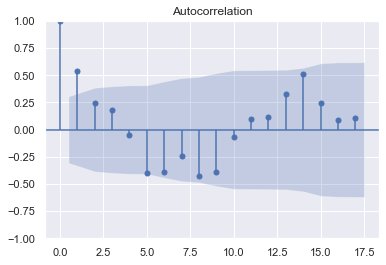

In [68]:
acfSalesScaled = acf(data_agg["Sales"].values, fft=True, nlags=40)
acfSalesScaledNp = np.array(acfSalesScaled)
corrPlots(acfSalesScaledNp)

<Figure size 2160x360 with 0 Axes>

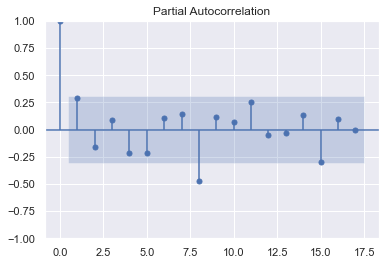

In [69]:
pacfSalesScaled = pacf(data_agg["Sales"].values, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)
corrPlots(pacfSalesScaledNp, is_partial=True)

In [70]:
scaled_df, scaler_obj = add_scaled_sales(data_agg)
data_agg["Sales"].isna().any().sum()

0

In [71]:
class TimeSeriesSalsesPred:
    
    def __init__(self, WINDOW_SIZE, BATCH_SIZE, sales_data):
        self.WINDOW_SIZE = WINDOW_SIZE
        self.BATCH_SIZE = BATCH_SIZE
        
        data_agg = sales_data.groupby("Date").agg({"Sales": "mean"})
        self.SIZE = len(data_agg["Sales"])

        self.scaled_df, self.scaler_obj = add_scaled_sales(data_agg)
        
        self.DateTrain = np.reshape(self.scaled_df.index.values[0:BATCH_SIZE], (-1, 1))
        self.DateValid = np.reshape(self.scaled_df.index.values[BATCH_SIZE:], (-1, 1))
        
        self.train_sales, self.valid_sales, self.TrainDataset, self.ValidDataset = self.prepare_data(WINDOW_SIZE,
                                                                                                     BATCH_SIZE, 
                                                                                                     self.scaled_df)
    
    def prepare_data(self, WINDOW_SIZE, BATCH_SIZE, scaled_df):
        train_sales = scaled_df["scaled_sales"].values[0:BATCH_SIZE].astype('float32')
        valid_sales = scaled_df["scaled_sales"].values[BATCH_SIZE:].astype('float32')
        TrainDataset = self.windowed_dataset(train_sales, WINDOW_SIZE, BATCH_SIZE)
        ValidDataset = self.windowed_dataset(valid_sales, WINDOW_SIZE, BATCH_SIZE)
        
        return train_sales, valid_sales, TrainDataset, ValidDataset
    
    def train(self, EPOCHS, verbose=1, ):
        model = Sequential()
        model.add(LSTM(20, input_shape=[None, 1], return_sequences=True))
        model.add(LSTM(10, input_shape=[None, 1]))
        model.add(Dense(1))
        model.compile(loss="huber_loss", optimizer='adam')
        model.summary()
        
        history = model.fit(self.TrainDataset, epochs=EPOCHS, validation_data=self.ValidDataset, verbose=verbose)
        
        self.plot_history(history)
        
        
        return model, history
    
    def plot_history(self, history):
        fig = plt.figure(figsize=(12, 9))
        plt.plot(history.history['loss'], label="loss")
        plt.plot(history.history['val_loss'], label="val_loss")
        plt.legend()
        plt.show()
        
        return fig
    
   
    def model_forecast_test(self, model):

        series = self.scaled_df["scaled_sales"].values[:, np.newaxis]

        ds = tf.data.Dataset.from_tensor_slices(series)
        ds = ds.window(self.WINDOW_SIZE, shift=1, drop_remainder=True) 
        ds = ds.flat_map(lambda w: w.batch(self.WINDOW_SIZE))
        ds = ds.batch(self.SIZE).prefetch(1)
        forecast = model.predict(ds)
        
        Results = forecast[self.BATCH_SIZE-self.WINDOW_SIZE:-1]
        Results1 = self.scaler_obj.inverse_transform(Results.reshape(-1,1))
        XValid1 = self.scaler_obj.inverse_transform(self.valid_sales.reshape(-1,1))
        
        fig, MAE, RMSE = self.plot_forcast(Results, Results1, XValid1, self.DateValid, self.WINDOW_SIZE)
        
        
        return forecast, fig, MAE, RMSE
    
    def plot_forcast(self, Results, Results1, XValid1, DateValid,  WINDOW_SIZE):
        fig = plt.figure(figsize=(30, 8))
        plt.title("LSTM Model Forecast Compared to Validation Data")
        
        plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
        plt.plot(DateValid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
        
        plt.xlabel('Date')
        plt.ylabel('Thousands of Units')
        plt.xticks(DateValid.astype('datetime64')[:,-1], rotation = 90) 
        plt.legend(loc="upper right")

        MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
        RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

        textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

        # place a text box in upper left in axes coords
        plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
        plt.grid(True)

        plt.show()
        
        return fig, MAE, RMSE
    
        
        

    
    def windowed_dataset(self, series, window_size, batch_size): 
        series = tf.expand_dims(series, axis=-1)
        dataset = tf.data.Dataset.from_tensor_slices(series)
        dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
        dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
        dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
        dataset = dataset.batch(batch_size).prefetch(1)
        return dataset

In [72]:
SIZE = len(data_agg["Sales"])
WINDOW_SIZE = 49
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 400

t = TimeSeriesSalsesPred(WINDOW_SIZE, BATCH_SIZE, data)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 20)          1760      
                                                                 
 lstm_1 (LSTM)               (None, 10)                1240      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 3,011
Trainable params: 3,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
1/1 [==============================] - 13s 13s/step - loss: 0.0550 - val_loss: 0.0539
Epoch 2/400
1/1 [==============================] - 0s 280ms/step - loss: 0.0493 - val_loss: 0.0481
Epoch 3/400
1/1 [==============================] - 0s 304ms/step - loss: 0.0440 - val_loss: 0.0429
Epoch 4/400
1/1 [=====

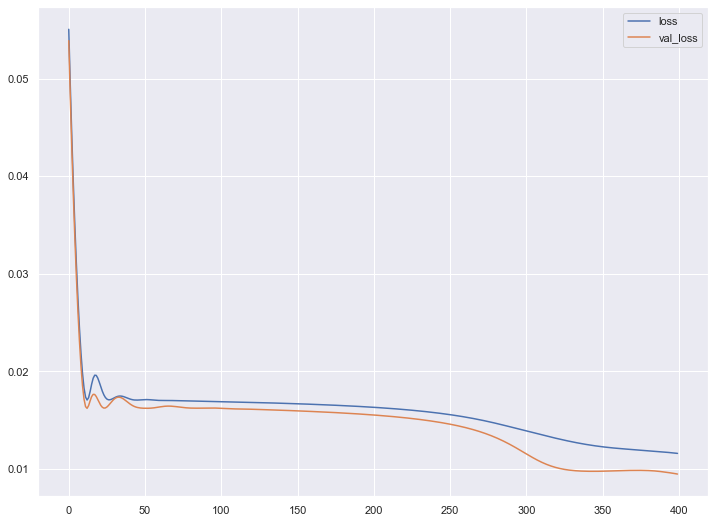

In [73]:
model1, his = t.train(EPOCHS)

1/1 [==============================] - 2s 2s/step


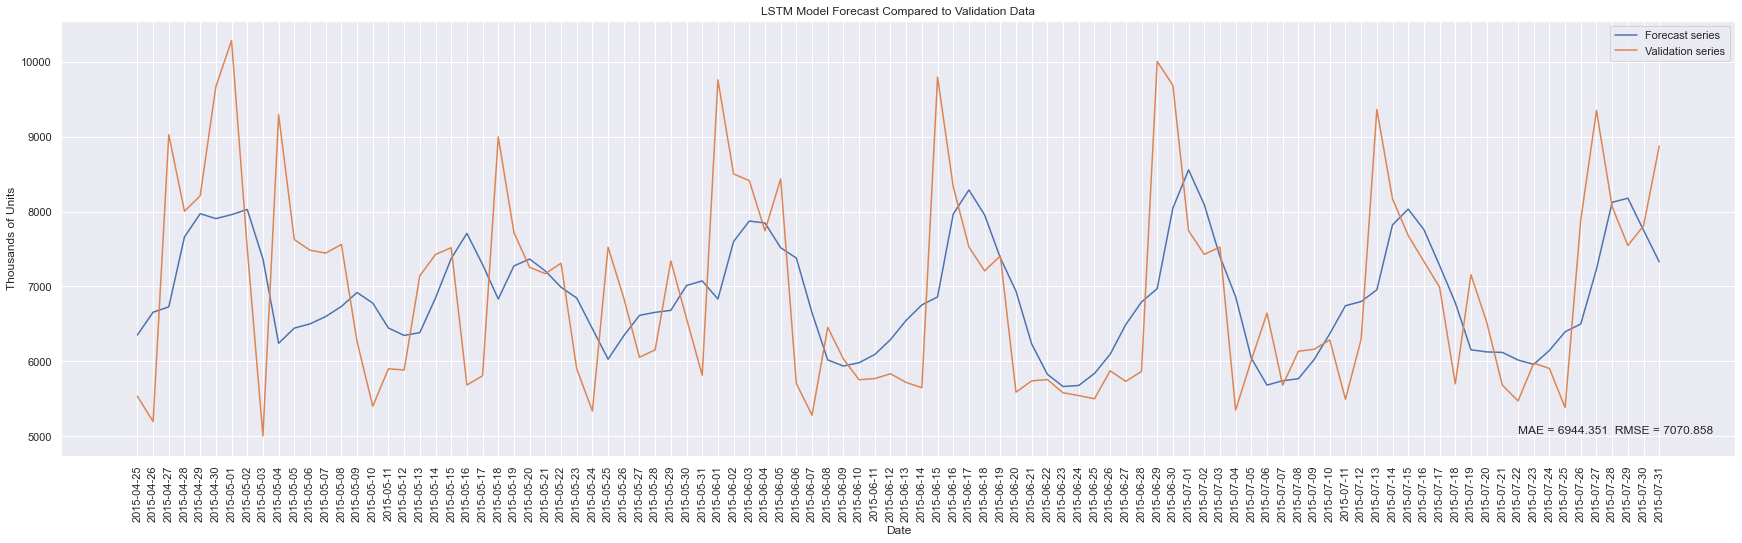

In [74]:
forecast, fig, MAE, RMSE = t.model_forecast_test(model1)

In [75]:
def forcast_next_one_sale(model, sales):
    data_feat = None
    WINDOW_SIZE = 49
    try:
        data_feat = sales[["Sales", "Date"]]
        
        if (data_feat.shape[0] < 49):
            print("To make prediction, we need atleast data of 49 dates")
            return
        scaled_df, scaler_obj = add_scaled_sales(data_feat)
        data_feat["Sales"].isna().any().sum()
        SIZE = len(data_agg["Sales"])
        
        
        series = scaled_df["scaled_sales"].values[:, np.newaxis]

        ds = tf.data.Dataset.from_tensor_slices(series)
        ds = ds.window(WINDOW_SIZE, shift=1, drop_remainder=True) 
        ds = ds.flat_map(lambda w: w.batch(WINDOW_SIZE))
        ds = ds.batch(SIZE).prefetch(1)
        
        forecast = model.predict(ds)
        Results = list(forecast.reshape(1, forecast.shape[0] * forecast.shape[1])[0].copy())

        Results1 = scaler_obj.inverse_transform(forecast.reshape(-1,1))
        Results1 = list(Results1.reshape(1, Results1.shape[0] * Results1.shape[1])[0])
        
    

        
        return  Results1, Results
        
    except KeyError:
        print("Sales Data is expeceted to have Sales and Date columns")
        return False
        
        

def forcast_next_sales(model, sales, daysToForcast=1):
    forcasts = []
    scaled_forcasts = []
    dates = []
    
    new_sales_df = sales.copy()
    while len(forcasts) < daysToForcast:
        forcast, scaled_forcast = forcast_next_one_sale(model1, new_sales_df)
        forcasts += forcast
        
        scaled_forcasts += scaled_forcast
        size=len(new_sales_df["Sales"])
        
        truncated_sales = new_sales_df.tail(size - len(scaled_forcast))
                
        new_sales = truncated_sales['Sales'].to_list() + scaled_forcast
        next_dates = []
        
        for i in range(len(scaled_forcast)):
            next_date = new_sales_df["Date"].to_list()[-1] + datetime.timedelta(days=1)
            next_dates.append(next_date)     
        
        new_dates = truncated_sales['Date'].to_list() + next_dates
        new_sales_df = pd.DataFrame()
        new_sales_df["Date"] = new_dates
        new_sales_df["Sales"] = new_sales
    
    res_df = pd.DataFrame()
    res_df["Date"] = new_dates
    res_df["forcasts"] = forcasts
    
    return res_df


In [79]:
data_agg["Date"] = data_agg.index
data_agg["Date"] = data_agg["Date"].astype("datetime64")
res_df = forcast_next_sales(model1, data_agg.head(49), 49)
res_df

1/1 [==============================] - 0s 52ms/step


,Date,forcasts
0,2013-02-19,7660.748047
1,2013-02-20,4504.058105
2,2013-02-21,3091.900146
3,2013-02-22,2158.618408
4,2013-02-23,1664.413940
5,2013-02-24,1493.697632
6,2013-02-25,1582.153198
7,2013-02-26,1895.449341
8,2013-02-27,2451.228760
9,2013-02-28,3062.133301


In [80]:
model1.save("../models/lstm_sales_pred_model.h5")